In [51]:
import numpy as np
from scipy import special
from scipy import sparse
from scipy.sparse import linalg as slinalg
import matplotlib.pyplot as plt
import tabulate
import time
import types

np.set_printoptions(linewidth=200)
np.random.seed(123)

Concern the following time fractional Allen-Cahn equation
$$
\partial_t^\alpha u = \varepsilon^2 \Delta u  -f(u) \quad \text{for}\ \ x\in \Omega\ \ \text{and}\ \ t > 0.
$$

A Crank-Nicolson type scheme
$$
\begin{align*}
&\partial_{\tau} u^{n-\frac12} = \left( ^R\partial_{\tau}^{1-\alpha}v \right)^{n-\frac12}\quad \text{for} ~~ 1\leq n\leq N,\\
&v^{n-\frac12} = \varepsilon^2 D_h u^{n-\frac12} - H(u^n,u^{n-1})\quad \text{for} ~~ 1\leq n\leq N,
\end{align*}
$$

where the vector $H(u^n,u^{n-1})$ is defined in the element-wise with the Hadamard product "$\circ$",
$$
H(u^n,u^{n-1}):= \frac13(u^n)^{3} + \frac12(u^{n-1})^2\circ u^n + \frac16(u^{n-1})^3 - \frac12(u^n + u^{n-1})
$$

In [52]:
class TFAC_2D_solver():
    def __init__(self,
                 alpha,
                 eps=0.05,
                 u0="random",
                 s_domain=[0,2*np.pi],
                 t_domain=[0,40],
                 M=128,
                 step_type="adaptive",
                 step_setup = {}):
                 
        # equation parameters
        self.alpha = alpha 
        self.eps = eps
        self.s_domain = s_domain
        self.t_domain = t_domain

        # spatial discrete
        self.M = M
        self.h = (s_domain[1] - s_domain[0])/M
        x = np.linspace(s_domain[0],s_domain[1],M+1)[:-1]
        self.X,self.Y = np.meshgrid(x,x)

        # double wall potential
        self.F = lambda u: (1-u**2)**2/4
        self.f = lambda u: u**3 - u

        # periodic discrete Laplace matrix
        I1 = np.eye(M,M)
        D1 = np.diag(-2*np.ones(M)) + np.diag(np.ones(M-1),-1) + np.diag(np.ones(M-1),1)
        D1[0,-1] = D1[-1,0] = 1; D1 /= self.h**2
        self.Dh = sparse.kron(I1,D1) + sparse.kron(D1,I1)

        # initial condition
        if isinstance(u0,str) and u0 == "random":
            self.U = np.random.uniform(-0.01,0.01,(1,M*M))
        elif isinstance(u0,np.ndarray):
            self.U = u0
        elif isinstance(u0,types.FunctionType):
            self.U = u0(self.X,self.Y).reshape((1,M*M))
        self.V = (eps**2*self.Dh@self.U[0] - self.f(self.U[0]))[np.newaxis,:]
        
        # time step setup 
        T0 = min(0.01,self.t_domain[1])
        self.N0 = 30; ga = 3
        self.t_k = np.array([T0*(i/self.N0)**ga for i in np.arange(self.N0+1)])
        self.tau_k = np.diff(self.t_k)

        if step_type == "uniform":
            self.step_size = self.uniform_step_size
            self.size = step_setup.get("step",1e-2)
        elif step_type == "adaptive":
            self.step_size = self.adaptive_step_size
            self.kap = step_setup.get("kappa",10)
            self.tau_min = step_setup.get("tau_min",1e-3)
            self.tau_max = step_setup.get("tau_max",1e-1)

        # Solution Property
        self.energys = np.empty((0,))
        self.modified_energys = np.empty((0,))

        # Integral Kernels
        self.q = np.empty((0,0))
        self.q_e = np.empty((0,0))


    def uniform_step_size(self,k):
        return self.size

    def adaptive_step_size(self,k):
        return max(self.tau_min,
                   self.tau_max/np.sqrt(1+self.kap*((self.modified_energys[k]-self.modified_energys[k-1])/self.tau_k[k-1])**2))

    def solve(self):
        k = 0
        T1 = time.perf_counter()
        self.energys = np.append(self.energys,self.Energy(k))
        self.modified_energys = np.append(self.modified_energys,self.Energy(0))
        while True:
            k += 1

            T2 = time.perf_counter()
            print(f"[{k} | Current time: {self.t_k[k]:.5f} | Step Size {self.tau_k[k-1]:.4f}| {(T2-T1):1.2f}s]",end="\r")
            T1 = T2

            self.step(k)
            self.energys = np.append(self.energys,self.Energy(k))
            self.modified_energys = np.append(self.modified_energys,self.Modified_Energy(k))

            if k>=self.N0:
                if self.t_k[-1]<self.t_domain[1]:
                    tau = self.step_size(k)
                    if self.t_k[-1] + tau > self.t_domain[1]:
                        tau = self.t_domain[1] - self.t_k[-1]
                    t = self.t_k[-1] + tau
                    self.t_k = np.append(self.t_k,t)
                    self.tau_k = np.append(self.tau_k,tau)
                else:
                    break
        print("\n")

    def step(self,k):
        # auxillary sequence: q
        q_tem = ((self.t_k[k] - self.t_k[:k][::-1])**(self.alpha) - (self.t_k[k] - self.t_k[1:k+1][::-1])**(self.alpha))/special.gamma(1+self.alpha)
            
        self.q = np.pad(self.q,((0,1),(0,1))); self.q[k-1] = q_tem 
        # discrete convoluation kernel: a
        a = (self.q[k-1] - np.roll(self.q[k-2],1))[:k]

        g1 = self.U[k-1] + a[0]*self.V[k-1]/2 + np.sum(a[1:k][::-1][:,np.newaxis]*(self.V[1:k] + self.V[:k-1])/2,axis=0) 
        g2 = self.eps**2/2*self.Dh@self.U[k-1] - self.U[k-1]**3/6 + (self.U[k-1] - self.V[k-1])/2

        A = sparse.bmat([[sparse.eye(self.M*self.M),-a[0]/2*sparse.eye(self.M*self.M)],
                        [-self.eps**2/2*self.Dh - 1/2*sparse.eye(self.M*self.M) + sparse.diags(self.U[k-1]**2)/2,1/2*sparse.eye(self.M*self.M)]])
        B = sparse.diags(np.ones(self.M*self.M)/3,offsets =-self.M*self.M,shape=A.shape,format="csr")

        def func(x):
            return A@x + B@(x**3) - np.hstack([g1,g2])
        def Dfunc(x):
            return A + sparse.diags(np.ones(self.M*self.M)*(x[:self.M*self.M])**2,offsets =-self.M*self.M,shape=A.shape,format="csr")

        # Newton's method
        up =  np.hstack([self.U[k-1],self.V[k-1]])+0.0001*np.random.rand(2*self.M*self.M)
        factor = 1
        for _ in range(500):
            u = up - factor*slinalg.spsolve(Dfunc(up),func(up))
            if np.max(np.abs(up - u)) < 1e-8:
                break
            up = u

        self.U = np.concatenate([self.U, u[:self.M*self.M][np.newaxis,:]],axis = 0)
        self.V = np.concatenate([self.V, u[self.M*self.M:][np.newaxis,:]],axis = 0)

    def Energy(self,k):
        energy = self.h**2*np.sum(self.F(self.U[k])) - self.eps**2*self.h**2/2*(self.U[k]@self.Dh@self.U[k])
        return energy
            
    def Modified_Energy(self,k):
        modified_energy = self.energys[k] + self.h**2*np.sum(self.q[k-1][::-1][:,np.newaxis]*((self.V[1:k+1] + self.V[:k])/2)**2)/2
        return modified_energy

# Adaptive Time Stepping

In [53]:
M = 128
u0 = np.random.uniform(-0.01,0.01,(1,M*M))
TFAC_ka_10 = TFAC_2D_solver(alpha=0.7,u0=u0,t_domain=[0,40],M=M,step_setup={"kappa":10})
TFAC_ka_100 = TFAC_2D_solver(alpha=0.7,u0=u0,t_domain=[0,40],M=M,step_setup={"kappa":100})
TFAC_ka_1000 = TFAC_2D_solver(alpha=0.7,u0=u0,t_domain=[0,40],M=M,step_setup={"kappa":1000})
TFAC_Uniform = TFAC_2D_solver(alpha=0.7,u0=u0,t_domain=[0,40],M=M,step_type="uniform")

T1 = time.perf_counter()
TFAC_ka_10.solve()
ka_10_elapse = time.perf_counter() - T1

T1 = time.perf_counter()
TFAC_ka_100.solve()
ka_100_elapse = time.perf_counter() - T1

T1 = time.perf_counter()
TFAC_ka_1000.solve()
ka_1000_elapse = time.perf_counter() - T1

T1 = time.perf_counter()
TFAC_Uniform.solve()
uniform_elapse = time.perf_counter() - T1

[514 | Current time: 40.00000 | Step Size 0.0818| 1.05s]

[825 | Current time: 40.00000 | Step Size 0.0897| 1.25s]

[1976 | Current time: 40.00000 | Step Size 0.0640| 1.70s]

[4029 | Current time: 40.00000 | Step Size 0.0100| 2.66s]



In [56]:
# Table 4: Comparisons of CPU time and time steps
table_data = [["Adaptive parameter", "kappa = 10", "kappa = 100", "kappa = 1000", "uniform mesh"],
              ["CPU time",f"{ka_10_elapse:5.1f}",f"{ka_100_elapse:5.1f}",f"{ka_1000_elapse:5.1f}",f"{uniform_elapse:5.1f}"],
              ["Time steps", TFAC_ka_10.tau_k.size,TFAC_ka_100.tau_k.size,TFAC_ka_1000.tau_k.size,TFAC_Uniform.tau_k.size]]

print(tabulate.tabulate(table_data,headers = "firstrow",tablefmt="fancy_grid",stralign="center",numalign = "center"))

╒══════════════════════╤══════════════╤═══════════════╤════════════════╤════════════════╕
│  Adaptive parameter  │  kappa = 10  │  kappa = 100  │  kappa = 1000  │  uniform mesh  │
╞══════════════════════╪══════════════╪═══════════════╪════════════════╪════════════════╡
│       CPU time       │    478.5     │     829.2     │     2578.5     │     6931.1     │
├──────────────────────┼──────────────┼───────────────┼────────────────┼────────────────┤
│      Time steps      │     514      │      825      │      1976      │      4029      │
╘══════════════════════╧══════════════╧═══════════════╧════════════════╧════════════════╛


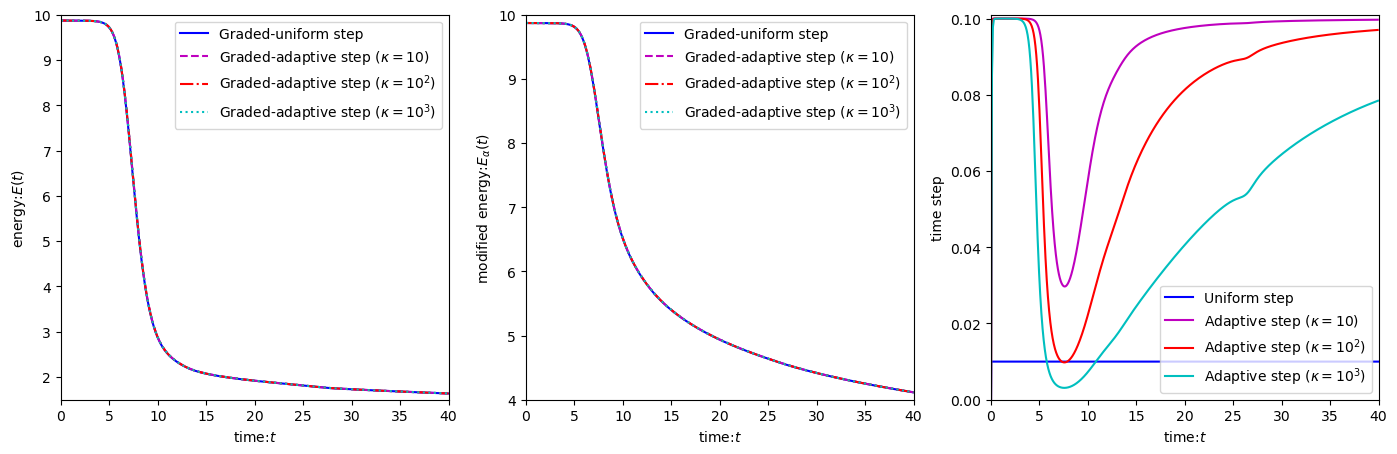

In [140]:
# Figure 5: The energies and adaptive steps
fig = plt.figure(figsize=(17,5))
ax1 = plt.subplot(1,3,1)
ax1.plot(TFAC_Uniform.t_k,TFAC_Uniform.energys,"b-",label="Graded-uniform step")
ax1.plot(TFAC_ka_10.t_k,TFAC_ka_10.energys,"m--",label = r"Graded-adaptive step ($\kappa = 10$)")
ax1.plot(TFAC_ka_100.t_k,TFAC_ka_100.energys,"r-.",label = r"Graded-adaptive step ($\kappa = 10^2$)")
ax1.plot(TFAC_ka_1000.t_k,TFAC_ka_1000.energys,"c:",label = r"Graded-adaptive step ($\kappa = 10^3$)")
ax1.set_xlim(0,40)
ax1.set_ylim(1.5,10)
ax1.set_xlabel(r"time:$t$")
ax1.set_ylabel(r"energy:$E(t)$")
ax1.legend()

ax2 = plt.subplot(1,3,2)
ax2.plot(TFAC_Uniform.t_k,TFAC_Uniform.modified_energys,"b-",label="Graded-uniform step")
ax2.plot(TFAC_ka_10.t_k,TFAC_ka_10.modified_energys,"m--",label = r"Graded-adaptive step ($\kappa = 10$)")
ax2.plot(TFAC_ka_100.t_k,TFAC_ka_100.modified_energys,"r-.",label = r"Graded-adaptive step ($\kappa = 10^2$)")
ax2.plot(TFAC_ka_1000.t_k,TFAC_ka_1000.modified_energys,"c:",label = r"Graded-adaptive step ($\kappa = 10^3$)")
ax2.set_xlim(0,40)
ax2.set_ylim(4,10)
ax2.set_xlabel(r"time:$t$")
ax2.set_ylabel(r"modified energy:$E_{\alpha}(t)$")
ax2.legend()

ax3 = plt.subplot(1,3,3)
ax3.plot(TFAC_Uniform.t_k[1:-1],TFAC_Uniform.tau_k[:-1],"b",label = "Uniform step")
ax3.plot(TFAC_ka_10.t_k[1:-1],TFAC_ka_10.tau_k[:-1],"m",label = r"Adaptive step ($\kappa = 10$)")
ax3.plot(TFAC_ka_100.t_k[1:-1],TFAC_ka_100.tau_k[:-1],"r",label = r"Adaptive step ($\kappa = 10^2$)")
ax3.plot(TFAC_ka_1000.t_k[1:-1],TFAC_ka_1000.tau_k[:-1],"c",label = r"Adaptive step ($\kappa = 10^3$)")
ax3.set_xlim(0,40)
ax3.set_ylim(0,0.101)
ax3.set_xlabel(r"time:$t$")
ax3.set_ylabel(r"time step")
ax3.legend(loc = "lower right")

# Solution Snapshots

In [57]:
M = 128
u0 = np.random.uniform(-0.01,0.01,(1,M*M))

TFAC_alpha_04 = TFAC_2D_solver(alpha=0.4,u0=u0,t_domain=[0,300],M=M,step_setup={"kappa":1000})
TFAC_alpha_07 = TFAC_2D_solver(alpha=0.7,u0=u0,t_domain=[0,300],M=M,step_setup={"kappa":1000})
TFAC_alpha_09 = TFAC_2D_solver(alpha=0.9,u0=u0,t_domain=[0,300],M=M,step_setup={"kappa":1000})

TFAC_alpha_04.solve()
TFAC_alpha_07.solve()
TFAC_alpha_09.solve()

[4363 | Current time: 300.00000 | Step Size 0.0976| 2.80s]

[4624 | Current time: 300.00000 | Step Size 0.0264| 2.90s]

[4389 | Current time: 300.00000 | Step Size 0.0950| 2.83s]



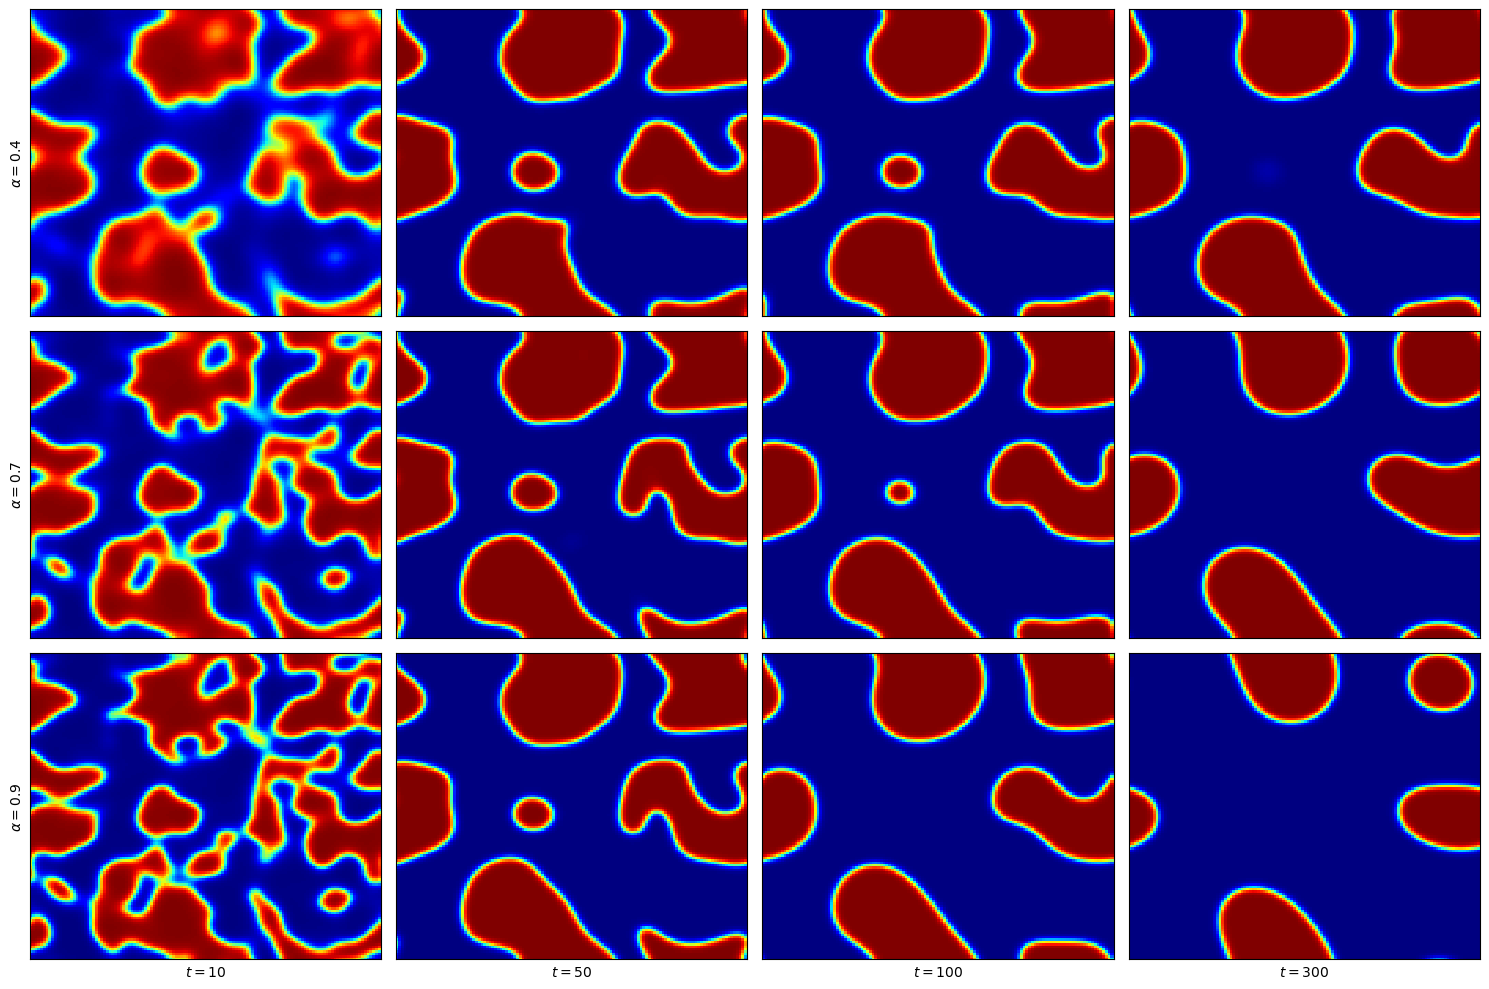

In [104]:
# Figure 6: Solution snapshots 
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(3,4,1)
ax1.pcolor(TFAC_alpha_04.U[677].reshape(TFAC_alpha_04.M,-1),cmap="jet")
ax1.set_ylabel(r"$\alpha = 0.4$")
ax2 = plt.subplot(3,4,2)
ax2.pcolor(TFAC_alpha_04.U[1783].reshape(TFAC_alpha_04.M,-1),cmap="jet")
ax3 = plt.subplot(3,4,3)
ax3.pcolor(TFAC_alpha_04.U[2337].reshape(TFAC_alpha_04.M,-1),cmap="jet")
ax4 = plt.subplot(3,4,4)
ax4.pcolor(TFAC_alpha_04.U[-1].reshape(TFAC_alpha_04.M,-1),cmap="jet")

ax5 = plt.subplot(3,4,5)
ax5.pcolor(TFAC_alpha_07.U[1030].reshape(TFAC_alpha_07.M,-1),cmap="jet")
ax5.set_ylabel(r"$\alpha = 0.7$")
ax6 = plt.subplot(3,4,6)
ax6.pcolor(TFAC_alpha_07.U[2066].reshape(TFAC_alpha_07.M,-1),cmap="jet")
ax7 = plt.subplot(3,4,7)
ax7.pcolor(TFAC_alpha_07.U[2605].reshape(TFAC_alpha_07.M,-1),cmap="jet")
ax8 = plt.subplot(3,4,8)
ax8.pcolor(TFAC_alpha_07.U[-1].reshape(TFAC_alpha_07.M,-1),cmap="jet")

ax9 = plt.subplot(3,4,9)
ax9.pcolor(TFAC_alpha_09.U[1115].reshape(TFAC_alpha_09.M,-1),cmap="jet")
ax9.set_ylabel(r"$\alpha = 0.9$")
ax9.set_xlabel(r"$t = 10$")
ax10 = plt.subplot(3,4,10)
ax10.pcolor(TFAC_alpha_09.U[1858].reshape(TFAC_alpha_09.M,-1),cmap="jet")
ax10.set_xlabel(r"$t = 50$")
ax11 = plt.subplot(3,4,11)
ax11.pcolor(TFAC_alpha_09.U[2380].reshape(TFAC_alpha_09.M,-1),cmap="jet")
ax11.set_xlabel(r"$t = 100$")
ax12 = plt.subplot(3,4,12)
ax12.pcolor(TFAC_alpha_09.U[-1].reshape(TFAC_alpha_09.M,-1),cmap="jet")
ax12.set_xlabel(r"$t = 300$")

plt.setp([globals()[f"ax{i}"] for i in range(1,13)],xticks =[],yticks = [])
plt.tight_layout()

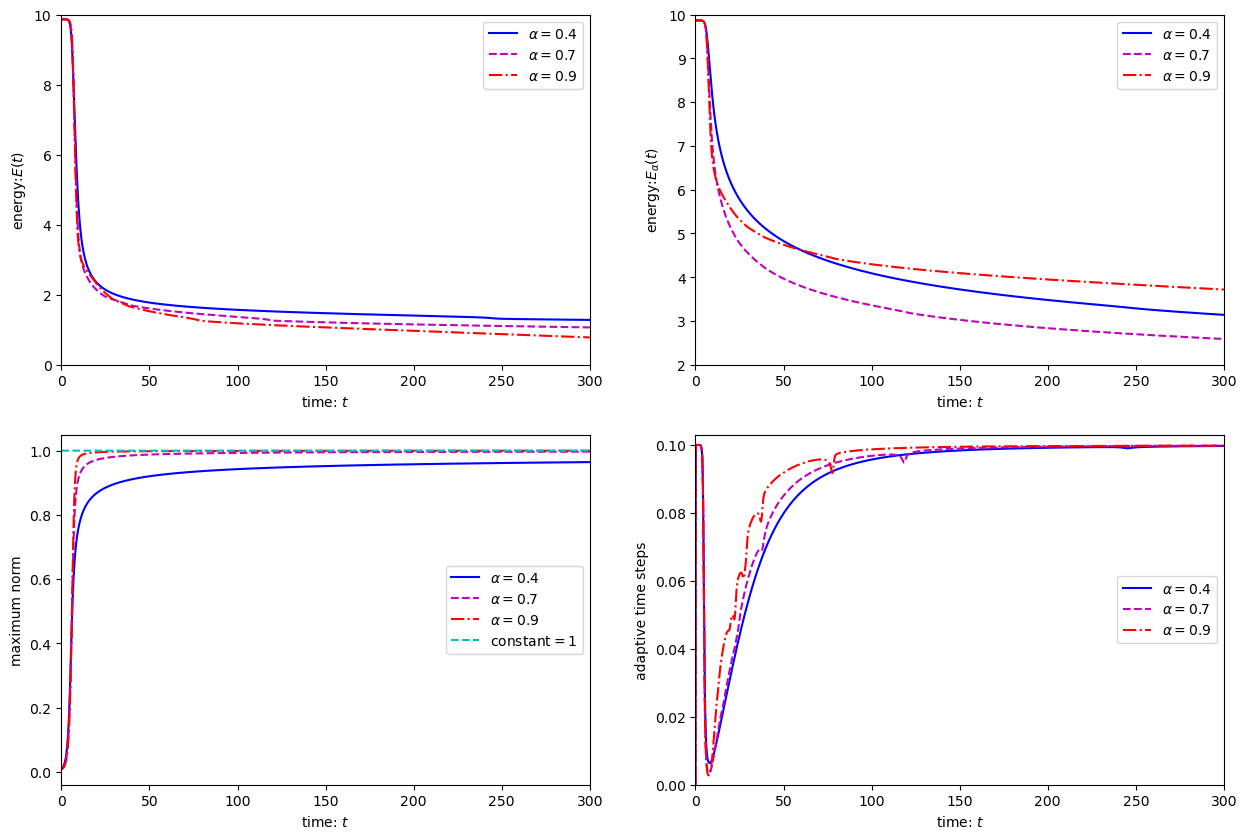

In [139]:
# Figure 7: Evolutions of energies, maximum norm and adaptive time steps
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,2,1)
ax1.plot(TFAC_alpha_04.t_k,TFAC_alpha_04.energys,"b-",label = r"$\alpha = 0.4$")
ax1.plot(TFAC_alpha_07.t_k,TFAC_alpha_07.energys,"m--",label = r"$\alpha = 0.7$")
ax1.plot(TFAC_alpha_09.t_k,TFAC_alpha_09.energys,"r-.",label = r"$\alpha = 0.9$")
ax1.set_ylabel(r"energy:$E(t)$")
ax1.set_xlabel(r"time: $t$")
ax1.set_xlim(0,300)
ax1.set_ylim(0,10)
ax1.legend()

ax2 = plt.subplot(2,2,2)
ax2.plot(TFAC_alpha_04.t_k,TFAC_alpha_04.modified_energys,"b-",label = r"$\alpha = 0.4$")
ax2.plot(TFAC_alpha_07.t_k,TFAC_alpha_07.modified_energys,"m--",label = r"$\alpha = 0.7$")
ax2.plot(TFAC_alpha_09.t_k,TFAC_alpha_09.modified_energys,"r-.",label = r"$\alpha = 0.9$")
ax2.set_ylabel(r"energy:$E_{\alpha}(t)$")
ax2.set_xlabel(r"time: $t$")
ax2.set_xlim(0,300)
ax2.set_ylim(2,10)
ax2.legend()

ax3 = plt.subplot(2,2,3)
ax3.plot(TFAC_alpha_04.t_k,np.max(TFAC_alpha_04.U,axis = 1),"b-",label = r"$\alpha = 0.4$")
ax3.plot(TFAC_alpha_07.t_k,np.max(TFAC_alpha_07.U,axis = 1),"m--",label = r"$\alpha = 0.7$")
ax3.plot(TFAC_alpha_09.t_k,np.max(TFAC_alpha_09.U,axis = 1),"r-.",label = r"$\alpha = 0.9$")
ax3.plot(np.linspace(0,300,3000),np.ones(3000),"c--",label = r"constant$= 1$")
ax3.set_ylabel(r"maximum norm")
ax3.set_xlabel(r"time: $t$")
ax3.set_xlim(0,300)
ax3.legend(loc = "right")

ax4 = plt.subplot(2,2,4)
ax4.plot(TFAC_alpha_04.t_k[1:-1],TFAC_alpha_04.tau_k[:-1],"b-",label = r"$\alpha = 0.4$")
ax4.plot(TFAC_alpha_07.t_k[1:-1],TFAC_alpha_07.tau_k[:-1],"m--",label = r"$\alpha = 0.7$")
ax4.plot(TFAC_alpha_09.t_k[1:-1],TFAC_alpha_09.tau_k[:-1],"r-.",label = r"$\alpha = 0.9$")
ax4.set_ylabel(r"adaptive time steps")
ax4.set_xlabel(r"time: $t$")
ax4.set_xlim(0,300)
ax4.set_ylim(0,0.103)
ax4.legend(loc = "right")